In [105]:
#This implementation encompasses 2 main ways for implementation of logistic regression, used on the "Breast Cancer: Wisconsin dataset":
#1. Newton's method of approaching the root to the gradient of log likelihood function.
#2. Simple batch gradient ascent to approaching the extremum of log likelihood function.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
#Importing all the basic libraries needed for our purpose.

In [106]:
data = load_breast_cancer()
X_raw = data.data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
#Scaling X for prevention of overflow in values.
ones = np.ones((X_scaled.shape[0], 1))
X = np.hstack([ones, X_scaled])
Y = data.target.reshape(-1, 1)
#Preparing the data for execution.
def sigmoid(z):
    z_clipped = np.clip(z, -500, 500)
    sigma_z = 1/(1 + np.exp(-z_clipped))
    return sigma_z
#Defining the sigmoid function.
print(X.shape)

(569, 31)


In [107]:
Q1 = np.zeros((X.shape[1], 1))
#Q1 denotes the first set of parameters that we will be using for Newton's method.
def grad1(X, Y, Q):
    Z = X @ Q
    G = sigmoid(Z)
    return X.T @ (Y - G)
#Defined the gradient for log likelihood function.
def hess1(X, Y, Q):
    Z = X @ Q
    G1 = sigmoid(Z)
    ones_ = np.ones((X.shape[0], 1))
    G2 = ones_ - G1
    G = G1 * G2
    #Defined a column matrix G of kth entry being gk(1 - gk) using Hadamard product, where gk = sigmoid(zk), where zk = xk*Q.
    #This column vector will eliminate the need for diagonal matrix in our standard formula for hessian, allowing lower time complexity.
    pairs_per_sample = np.einsum('ik, ij->ijk', X, X)
    pair_column_mat = pairs_per_sample.reshape(X.shape[0], -1)
    #Makes a matrix of shape (m, n^2) to be used for further operations.
    summation_columns = G * pair_column_mat
    #Now by summing all elements of each column, we get a total of n^2 elements. This will give us all the n^2 entries needed for our actual hessian.
    #This will take up a total of O(mn^2) complexity.
    hessian_entries = -np.sum(summation_columns, axis = 0)
    #Made a 1-D array of shape (n^2, )
    n = X.shape[1]
    hessian = hessian_entries.reshape(n, n)
    #This sets up our n x n hessian matrix to be used for further operations.
    return hessian
def softplus(Z):
    out = np.empty_like(Z, dtype=float)
    # mask for Z >= 0
    pos = (Z >= 0)
    # mask for Z < 0
    neg = ~pos
    # For Z >= 0: compute z + log1p(exp(-z)), and exp(-z) is safe (<=1)
    out[pos] = Z[pos] + np.log1p(np.exp(-Z[pos]))
    # For Z < 0: compute log1p(exp(z)), and exp(z) is safe (<=1)
    out[neg] = np.log1p(np.exp(Z[neg]))
    return out
def log_likelihood(X, Y, Q):
    Z = X @ Q
    Y1 = Y * Z
    ln_G = softplus(Z)
    Y2 = -ln_G
    sum_Y1 = np.sum(Y1, axis = 0)
    sum_Y2 = np.sum(Y2, axis = 0)
    #Summing the two columns to get our main function.
    return sum_Y1 + sum_Y2

In [108]:
#1. Newton's method:
i = 0
#Setting iterator at 0.
iters = int(1e4)
#Total no. of iterations (arbitrarily set for now)
damping_constant = 0.001
#A damping constant, to prevent values from blowing up.
logfunc = [log_likelihood(X, Y, Q1)]
#This will be our array to store the log-likelihood values at each iteration.
while(i < iters):
    H1 = hess1(X, Y, Q1)
    G1 = grad1(X, Y, Q1)
    #Getting our hessian and gradient per iteration.
    H1_inv = np.linalg.pinv(H1)
    Q1 -= damping_constant * (H1_inv @ G1)
    #Implementing basic newton's logistic regression with damped Newton-Raphson step.
    logfunc.append(log_likelihood(X, Y, Q1))
    i += 1

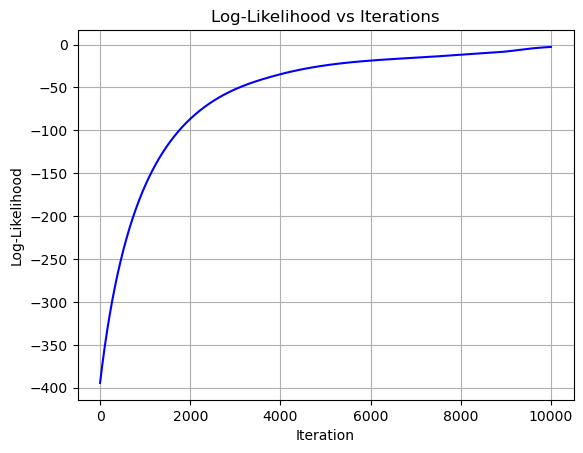

13683100.505918646


In [109]:
plt.plot(range(10001), logfunc, color = 'blue')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Iterations')
plt.grid(True)
plt.show()
#Simple plotting.
cond_num = np.linalg.cond(hess1(X, Y, Q1))
print(cond_num)
#This is a suggestion by chatGPT. The condition number of a Hessian is a certain value that allows us to tell if a Hessian is ill-conditioned or not.
#According to the output, i.e. 13683100.505918646, the Hessian is seriously ill-conditioned (since our condition number is in order of 10^7). And to repair that there are certain optimization techniques that I believe are beyond my level for now.
#Hence, leaving the implementation using Newton's logistic regression here only. Will revisit this later.

In [110]:
#2. Basic gradient ascent:
Q2 = np.zeros((X.shape[1], 1))
#Initialised Q2 as the new parameter vector.
i = 0
#Iterator again set to 0 for new iteration loop.
learning_rate = 0.05
#This almost functions like our decaying constant. It determines the size of each step towards achieving limit vector, that the algorithm should take.
logfunc_ = [log_likelihood(X, Y, Q2)]
#Array to plot log likelihood function wrt to iterations using Batch gradient ascent this time.
while(i < iters):
    G2 = grad1(X, Y, Q2)
    Q2 += learning_rate * G2
    #Basic updation algorithm.
    logfunc_.append(log_likelihood(X, Y, Q2))
    i += 1

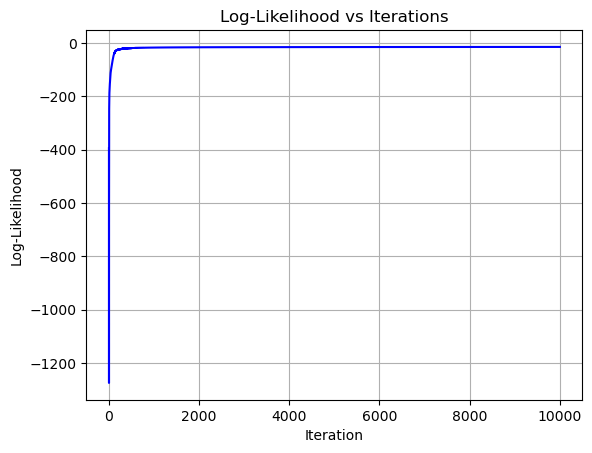

In [111]:
plt.plot(range(10001), logfunc_, color = 'blue')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Iterations')
plt.grid(True)
plt.show()
#Simple plotting.

# Overview
I would like to share my implementation of logistic regression regarding the two most commonly-used methods: Newton's algorithm and the Batch Gradient Ascent algorithm. This was a fruitful session, since I got better clarity on what resources I need to focus more on.

## Some mistakes, and learnings:
1. Not every algorithm can be reduced to have an analytic solution via a simple matrix solving formula. I tried setting the gradient of log likelihood function to 0, but the formula resulted in an equation like this:
    $X^{T} Y = X^{T} \sigma (X \theta)$.
    If I want to separate $\vec{\theta}$ from the equation, then $X^{T}$ will have to be invertible.. which may or may not be possible.
    However this does seem like an interesting "eigenvalue-like" equation. So would like to analyse it in the future.

2. A self-doubt I had was that how do "we" know that the gradient of log-likelihood function will follow Newton's algorithm? An example I thought of was:
    Suppose, we want to find the root of f($x$), where f($x$) = $sgn( \sqrt{|x|})$.
    This function follows the rule of oscillation via Newton's algorithm : $\frac{f(\theta_{0})}{f'(\theta_{0})} = \frac{f(\theta_{0} - \frac{f(\theta_{0})}{f'(\theta_{0})})}{f'(\theta_{0} - \frac{f(\theta_{0})}{f'(\theta_{0})})}$ which means that the value of $\theta_{k}$ will keep on oscillating between two points (where k denotes $k^{th}$ iteration), and never reach a single zero.
    But, turns out that the log-likelihood function does not satisfy this rule in any way, because it is a purely concave surface, with exactly one global maximum. This is related to convexity/concavity of surfaces, that I still do need to learn about.

3. For the last project on locally weighted regression, I used help of chatGPT to cook up a simplified formula for evaluation of $\vec{\theta}$, such that the overall complexity is decreased. This time, I tried coming up with my own way of computing the Hessian, such that time complexity is decreased to O($mn^{2}$) from O($m^{2}n$), where m is no. of samples and n is no. of features. The algorithm required a combination of simple matrix multiplication as well as Hadamard multiplication of rows and column. It also prompted me to learn about the "einsum" method in numpy, which is a clever vectorized loop to make pairs of numbers.

4. Upon the naive run of the algorithm, I found that entries of Z matrix were overflowing. Had not scaled X earlier. Hence, learned scaling X is a MUST in any algorithm. 

5. Didn't put the -ve sign with the Hessian computation $H = -X^{T}diag(g^{i}(1 - g^{i}))X$ earlier. This led to huge blowouts of $\theta$ values, in the order of $10^{13}$. Significant reduction in values upon correcting the mistake was observed, but the algorithm was far from converging.

6. A pure Newton-Raphson step (yeah, that's what it's called) can be huge. A decaying factor is needed to dampen the step and prevent any form of overshooting. Hence, added a decay constant along with the step. Again, significant reduction in divergence was seen.

7. Using the softplus function was an important part in calculating the log-likelihood function. It helped in preventing overflow/underflow of values with a boolean subsetting. Earlier, large overflows were detected in the function. (Simply said, it is an algebraic manipulation of the function $ln(1 + e^{z})$, which on approximation gives a perfectly accurate value for usage, without letting overflows or underflows occur.)

8. The sigmoid function also required "clipping of its values" to prevent the floating-point mechanism from exactly rounding to 0 or 1, which would cause values such as log(0) to be stored in the memory, aka an invalid value as such.

9. I also learned about some statistic values such as a "condition number" for a hessian, "ridge terms", "ill-conditioning", "convex-optimisation" etc. These seem to be advanced calculus concepts that I have not yet read about. These were the same reasons I had to postpone my "Bounding Convergence Point in BGD" project (Refer to week-1). I have gathered some resources on the required mathematics and optimization concepts that I still do need to learn (with the help of chatGPT). Will keep you guys updated!

Thank you for sticking around :)